In [1]:
import copy
import gym_blender
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from IPython import display
import pylab as pl
from collections import deque

import numpy as np
% matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# Deep-Q learning Agent
class DQNAgent:
    def __init__(self, env, image_dim):
        self.env = env
        self.num_actions = env.action_space.n
        self.memory = []
        self.gamma = 0.9  # decay rate
        self.epsilon = 1.0  # exploration
        self.epsilon_decay = .997
        self.epsilon_min = 0.1
        self.learning_rate = 0.00002
        self.image_dim = image_dim
        self.model = self._build_2dconv_model()
        
    def _build_2dconv_model(self):
        model = Sequential()
        
        print(self.image_dim)
        model.add(Conv2D(16, 8, 8, activation='relu', input_shape=self.image_dim))
        model.add(BatchNormalization())
        model.add(Conv2D(16, 5, 5, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(1, 2)))

        model.add(Conv2D(32, 3, 3, activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, 3, 3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(1, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(self.num_actions, activation='linear'))

        rms = RMSprop(lr=self.learning_rate)
        model.compile(loss='mean_squared_error', optimizer=rms)
                      
        print(model.summary())
        
        return model
    
    def remember(self, state, action, reward, next_state, done, max_len=150000):
        self.memory.append((state, action, reward, next_state, done))
        
        #forget if too old:
        if len(self.memory) > max_len:
            self.memory.pop(0)
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])  # returns action
    
    def train(self, batch_size, history_length):
        
        batch_size = min(batch_size, len(self.memory))
        # make sure there is at least history_length frames behind each batch state
        batche_indexes = np.random.choice(range(history_length,len(self.memory)), batch_size)
        
        # unpack minibatch:
        prestates = np.vstack([self.memory[index][0] for index in batche_indexes])
        actions = np.array([self.memory[index][1] for index in batche_indexes])
        rewards = np.array([self.memory[index][2] for index in batche_indexes])
        poststates = np.vstack([self.memory[index][3] for index in batche_indexes])
        terminals = np.array([self.memory[index][4] for index in batche_indexes])
        
        # forward passes:
        pre_q = self.model.predict(prestates)
        post_q = self.model.predict(poststates)
        max_post_q = np.array([np.amax(q) for q in post_q])
        
        targets = pre_q
        
        for i, action in enumerate(actions):
            if terminals[i]:
                targets[i, action] = float(rewards[i])
            else:
                targets[i, action] = float(rewards[i]) + self.gamma * max_post_q[i]
                
        self.model.fit(prestates, targets, nb_epoch=2, verbose=1)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


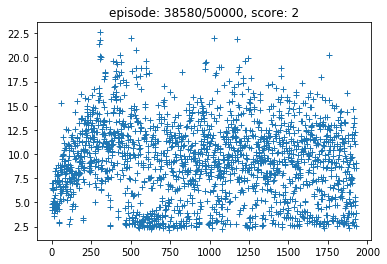

Epoch 1/2
32/32 [==============================] - 0s - loss: 6848.1074
Epoch 2/2
32/32 [==============================] - 0s - loss: 6803.2314
Epoch 1/2
32/32 [==============================] - 0s - loss: 7138.9883
Epoch 2/2
32/32 [==============================] - 0s - loss: 7109.8911
Epoch 1/2
32/32 [==============================] - 0s - loss: 5942.4414
Epoch 2/2
32/32 [==============================] - 0s - loss: 5887.8354
Epoch 1/2
32/32 [==============================] - 0s - loss: 8378.0645
Epoch 2/2
32/32 [==============================] - 0s - loss: 8351.5391
Epoch 1/2
32/32 [==============================] - 0s - loss: 6713.0566
Epoch 2/2
32/32 [==============================] - 0s - loss: 6686.7695
Epoch 1/2
32/32 [==============================] - 0s - loss: 5249.5835
Epoch 2/2
32/32 [==============================] - 0s - loss: 5230.0044
Epoch 1/2
32/32 [==============================] - 0s - loss: 12053.3047
Epoch 2/2
32/32 [==============================] - 0s - loss: 1

KeyboardInterrupt: 

In [3]:
history_length = 4

ridge_env = gym.envs.make('ridge-v0')

state = ridge_env._reset()
agent = DQNAgent(ridge_env, (history_length,)+state.shape)

episodes = 50000
all_scores = []
all_scores_means = []
# Iterate the game
for e in range(episodes):

    # reset state in the beginning of each game
    state = ridge_env._reset()
    state = np.expand_dims(np.expand_dims(state, 0), 0)
    # time_t represents each frame of the game
    # Our goal is to keep the pole upright as long as possible
    # the more time_t the more score
    states = deque([state]*history_length)
    for time_t in range(5000):
        # turn this on if you want to render
        # env.render()

        # Decide action
        action = agent.act(np.concatenate(states, axis=1))

        # Advance the game to the next frame based on the action.
        next_state, reward, done, _ = ridge_env.step(ridge_env.blender_interface.legal_action_set[action])

        # (reward defaults to 1)
        # reward the agent 1 for every frame it lived
        # and punish -1 for dying
        reward = -1 if done else 1
        
        next_state = np.expand_dims(np.expand_dims(next_state, 0), 0)
        # Remember the previous state, action, reward, and done

        # make next_state the new current state for the next frame.
        
        next_states = copy.deepcopy(states)
        next_states.rotate(-1)
        next_states[-1] = next_state
        
        agent.remember(np.concatenate(states, axis=1), action, 
                       reward, np.concatenate(next_states, axis=1), done)
        
        states = copy.deepcopy(next_states)

        # done becomes True when the game ends
        # ex) The agent drops the pole
        if done:
            # print the score and break out of the loop
            all_scores += [time_t]
            
            break
    # train the agent with the experience of the episode
    agent.train(batch_size=32, history_length=history_length)
    
    if e%20 == 0:
        all_scores_means += [np.mean(all_scores)]
        all_scores = []
        pl.plot(all_scores_means, '+')
        pl.title("episode: {}/{}, score: {}".format(e, episodes, time_t))
        display.clear_output(wait=True)
        display.display(pl.gcf())
        pl.close()
    
del agent.env
del ridge_env

In [4]:
del agent.env
del ridge_env

(array([  41880.,       0.,       0.,       0.,       0.,   52145.,
              0.,       0.,       0.,  105975.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

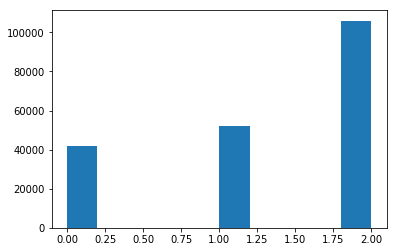

In [4]:
actions = []
for mem in agent.memory:
    actions += [mem[1]]
    
plt.hist(actions)

In [14]:
r

(1, 4, 37, 113)

In [1]:
for mem in agent.memory[0:100]:
    print('++++++++++++++++++++++++')
    print(mem[2])
    prestate = np.squeeze(mem[0])
    postsate = np.squeeze(mem[3])
    for state in prestate:
        plt.imshow(state)
        plt.show()
    print('========================')
    for state in postsate:
        plt.imshow(state)
        plt.show()

NameError: name 'agent' is not defined

In [5]:
agent.epsilon

0.0996820918179746

In [9]:
np.concatenate([state]*4, axis=1).shape

(1, 4, 65, 195)

In [6]:
state = np.expand_dims(np.expand_dims(state, 0), 0)

In [7]:
state.shape

(1, 1, 65, 195)

In [7]:
np.concatenate(states, axis=1)

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8)

In [7]:
agent.memory[0][0].shape

(1, 4, 23, 229)